
## **Problem Statement**:

**BoomBikes, a US-based bike-sharing provider, has recently experienced a significant decline in revenues. To address this issue, they have enlisted the help of a consulting firm to analyze and identify the key factors influencing the demand for shared bikes in the American market. BoomBikes is particularly interested in understanding:**

1. **Which variables are critical in predicting the demand for shared bikes.**
2. **The extent to which these variables explain the fluctuations in bike demand.**

**By gaining insights into these factors, BoomBikes aims to better anticipate customer needs and enhance their service offerings to improve revenue and market position.**

In [1]:
# Importing essential Libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

## **Reading, understanding, visualising and preparing the data**:

In [2]:
# Read and view the Dataset
day = pd.read_csv('day.csv')
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# Get to know about type of Data
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### Removing columns which are irrelevant to the analysis:
**instant**: Just contains the numbering of each row. <br>
**dteday**: Not required for analysis as the year and month have already been extracted and provided as separate columns, and the day is not relevant for our analysis. <br>

In [4]:
day = day.drop(['instant','dteday'],axis =1)

### Feature: "season" is categorical with four levels (1: spring, 2: summer, 3: fall, 4: winter), necessitating encoding with three dummy variables.

In [5]:
season_desc = pd.get_dummies(day['season'])
season_desc.head()

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [6]:
season_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       730 non-null    uint8
 1   2       730 non-null    uint8
 2   3       730 non-null    uint8
 3   4       730 non-null    uint8
dtypes: uint8(4)
memory usage: 3.0 KB


In [7]:
season_desc1 = season_desc.rename(columns={1:'spring', 2:'summer', 3:'fall', 4:'winter'},inplace = False)
season_desc1.sample(5)


,spring,summer,fall,winter
581,0,0,1,0
180,0,0,1,0
664,0,0,0,1
504,0,1,0,0
232,0,0,1,0


We can drop one of the four columns (for example, 'spring'), as each column can be explained by the remaining three. Let's explore how 'spring' can be represented using the remaining three columns:

*     000 corresponds to spring
*     100 corresponds to summer
*     010 corresponds to fall
*     001 corresponds to winter

In [8]:
day = pd.concat((day,season_desc1),axis=1)

In [9]:
day = day.drop(['season','spring'],axis=1)
day.sample(5)

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,summer,fall,winter
510,1,5,0,6,0,1,28.392500,32.13480,73.2500,13.332464,2855,3681,6536,1,0,0
332,0,11,0,2,1,2,18.791653,22.56875,83.0833,17.292164,96,2818,2914,0,0,1
20,0,1,0,5,1,1,7.277500,7.89165,45.7083,23.667214,75,1468,1543,0,0,0
693,1,11,0,0,0,1,10.079153,12.87915,46.8333,10.083500,309,2115,2424,0,0,1
124,0,5,0,4,1,1,18.825847,22.09585,44.4167,19.791264,614,3819,4433,1,0,0


In [10]:
Month = pd.get_dummies(day['mnth'])
Month.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
Month1 = Month.rename(columns={ 1:'Jan',2:'Feb',3:'March',4:'April',5:'May', \
                               6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace = False)
Month1.sample(5)

,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec
127,0,0,0,0,1,0,0,0,0,0,0,0
693,0,0,0,0,0,0,0,0,0,0,1,0
214,0,0,0,0,0,0,0,1,0,0,0,0
585,0,0,0,0,0,0,0,1,0,0,0,0
19,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
day = pd.concat((day,Month1),axis=1)
day.sample(5)

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,...,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec
130,0,5,0,3,1,1,22.242500,26.42000,63.2917,8.083014,...,0,0,1,0,0,0,0,0,0,0
714,1,12,0,0,0,2,14.862500,18.49690,83.8750,6.749714,...,0,0,0,0,0,0,0,0,0,1
718,1,12,0,4,1,2,13.530000,16.76085,66.7917,8.875021,...,0,0,0,0,0,0,0,0,0,1
551,1,7,0,5,1,1,33.961653,37.62665,45.0833,9.791514,...,0,0,0,0,1,0,0,0,0,0
8,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,...,0,0,0,0,0,0,0,0,0,0


### Since any one of the months can be explained by the remaining 11 months, we can drop the first one, 'Jan'. 
### Additionally, since we have already expanded the levels of the feature 'mnth', it is no longer needed.

In [13]:
day = day.drop(['mnth','Jan'],axis=1)


In [14]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   weekday     730 non-null    int64  
 3   workingday  730 non-null    int64  
 4   weathersit  730 non-null    int64  
 5   temp        730 non-null    float64
 6   atemp       730 non-null    float64
 7   hum         730 non-null    float64
 8   windspeed   730 non-null    float64
 9   casual      730 non-null    int64  
 10  registered  730 non-null    int64  
 11  cnt         730 non-null    int64  
 12  summer      730 non-null    uint8  
 13  fall        730 non-null    uint8  
 14  winter      730 non-null    uint8  
 15  Feb         730 non-null    uint8  
 16  March       730 non-null    uint8  
 17  April       730 non-null    uint8  
 18  May         730 non-null    uint8  
 19  June        730 non-null    u

### Feature: Understanding 'holiday'

The feature 'holiday' indicates whether a given day is a holiday or not. It is already encoded in binary form:
- **1** represents a holiday.
- **0** represents a non-holiday.

### Feature: Understanding 'weekday'

The 'weekday' feature represents the day of the week and requires encoding. It can be mapped as follows:

- **1:** Monday
- **2:** Tuesday
- **3:** Wednesday
- **4:** Thursday
- **5:** Friday
- **6:** Saturday
- **0:** Sunday


In [15]:
Weekday = pd.get_dummies(day['weekday'])
Weekday.sample(5)

,0,1,2,3,4,5,6
526,0,1,0,0,0,0,0
215,0,0,0,0,1,0,0
26,0,0,0,0,1,0,0
700,1,0,0,0,0,0,0
472,0,0,0,1,0,0,0


In [16]:
WEEKDAYS = Weekday.rename(columns={1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thrusday', \
                                   5:'Friday',6:'Saturday',0:'Sunday'},inplace = False)
WEEKDAYS.sample(7)

,Sunday,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday
22,1,0,0,0,0,0,0
660,0,0,1,0,0,0,0
190,1,0,0,0,0,0,0
31,0,0,1,0,0,0,0
289,0,1,0,0,0,0,0
43,1,0,0,0,0,0,0
703,0,0,0,1,0,0,0


In [17]:
day = pd.concat((day,WEEKDAYS),axis=1)
day.sample(5)

,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,...,Oct,Nov,Dec,Sunday,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday
722,1,0,1,1,2,9.483464,12.94500,79.1304,5.174437,174,...,0,0,1,0,1,0,0,0,0,0
379,1,0,0,0,1,6.833347,8.08125,41.9167,16.834286,284,...,0,0,0,1,0,0,0,0,0,0
80,0,0,2,1,1,18.108347,22.03210,62.4583,15.125250,460,...,0,0,0,0,0,1,0,0,0,0
182,0,0,6,0,1,30.271653,33.36540,44.4583,7.709154,2204,...,0,0,0,0,0,0,0,0,0,1
54,0,0,4,1,2,12.121732,14.45955,69.7391,16.783232,100,...,0,0,0,0,0,0,0,1,0,0


* As we have already Expanded the Feature 'weekday' so we don't need it.
* Since any one of the Weekday can be explained by remaining other 6 Weekdays. so we can drop 'Sunday'

In [18]:
day = day.drop(['weekday','Sunday'],axis=1)
day.sample(5)

,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,...,Sep,Oct,Nov,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday
147,0,0,0,1,26.889153,30.61895,72.9583,15.416164,2001,2757,...,0,0,0,0,0,0,0,0,0,1
491,1,0,1,2,22.037500,26.35710,66.4167,15.458307,1008,5265,...,0,0,0,0,1,0,0,0,0,0
583,1,0,1,2,30.169153,34.88105,70.3750,7.832836,1278,5995,...,0,0,0,0,0,1,0,0,0,0
51,0,1,0,2,12.436653,14.20375,60.5000,20.625682,195,912,...,0,0,0,0,1,0,0,0,0,0
257,0,0,1,2,23.677500,27.68355,70.9167,18.166782,428,3231,...,1,0,0,0,0,0,0,1,0,0


### Feature: Understanding 'workingday'

The 'workingday' feature indicates whether a day is a working day or not:
- **1** if the day is neither a weekend nor a holiday (i.e., it's a working day).
- **0** if the day is either a weekend or a holiday.

Since the 'workingday' feature is already binary encoded, no further data preparation is needed.

### Feature: Understanding 'weathersit'

The 'weathersit' feature describes the weather conditions with the following levels:
- **1:** Clear, Few clouds, Partly cloudy, Partly cloudy
- **2:** Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- **3:** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- **4:** Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog

Since 'weathersit' has four distinct levels, we can create dummy variables to represent them numerically. The mapping can be interpreted as:
- **1:** Clear
- **2:** Mist
- **3:** Light


In [19]:
Weathersit = pd.get_dummies(day['weathersit'])
Weathersit.sample(5)

,1,2,3
642,1,0,0
293,1,0,0
37,1,0,0
640,0,1,0
557,1,0,0


In [20]:
Weathersits = Weathersit.rename(columns = {1:'Clear' ,2: 'Mist' , 3: 'Light'},inplace = False)

In [21]:
day = pd.concat((day,Weathersits), axis =1)
day.sample(5)

,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,...,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday,Clear,Mist,Light
105,0,0,0,3,17.664153,21.27460,88.8333,22.834136,121,674,...,0,0,0,0,0,0,1,0,0,1
228,0,0,1,1,29.656653,33.33355,57.5417,9.625689,668,4026,...,0,0,0,1,0,0,0,1,0,0
437,1,0,1,1,23.472500,27.43085,50.7083,7.709154,997,5315,...,0,0,0,1,0,0,0,1,0,0
30,0,0,1,2,7.414153,9.31250,60.3750,12.541864,42,1459,...,0,1,0,0,0,0,0,0,1,0
676,1,0,1,1,14.439134,17.09455,33.3478,23.304945,340,4975,...,0,0,0,0,1,0,0,1,0,0


In [22]:
# As we don't need the Feature 'weathersit' now as we have already expanded so we can drop it
day = day.drop('weathersit',axis=1)


In [23]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   casual      730 non-null    int64  
 8   registered  730 non-null    int64  
 9   cnt         730 non-null    int64  
 10  summer      730 non-null    uint8  
 11  fall        730 non-null    uint8  
 12  winter      730 non-null    uint8  
 13  Feb         730 non-null    uint8  
 14  March       730 non-null    uint8  
 15  April       730 non-null    uint8  
 16  May         730 non-null    uint8  
 17  June        730 non-null    uint8  
 18  July        730 non-null    uint8  
 19  Aug         730 non-null    u

### Features and Target Variable Explanation

**Features:**
- Features such as 'temp', 'atemp', 'hum', 'windspeed', 'casual', and 'registered' are represented as integers and are expected to remain as integers.

**Target Variable:**
- The feature 'cnt' represents the count of total rental bikes, including both casual and registered rentals. It serves as the target variable for prediction tasks.

## **Data Visualization**:

In [24]:
# Visualization of Data Statistics 
day.describe().T.style.background_gradient(cmap = 'coolwarm',axis=1).set_precision(2)

,count,mean,std,min,25%,50%,75%,max
yr,730.00,0.50,0.50,0.00,0.00,0.50,1.00,1.00
holiday,730.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,730.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
temp,730.00,20.32,7.51,2.42,13.81,20.47,26.88,35.33
atemp,730.00,23.73,8.15,3.95,16.89,24.37,30.45,42.04
hum,730.00,62.77,14.24,0.00,52.00,62.62,72.99,97.25
windspeed,730.00,12.76,5.20,1.50,9.04,12.13,15.63,34.00
casual,730.00,849.25,686.48,2.00,316.25,717.00,1096.50,3410.00
registered,730.00,3658.76,1559.76,20.00,2502.25,3664.50,4783.25,6946.00
cnt,730.00,4508.01,1936.01,22.00,3169.75,4548.50,5966.00,8714.00


### Based on the numerical feature description provided:

1. **Outliers in 'casual':**
   - It's noted that 'casual' may have outliers. Outliers can significantly affect statistical analyses and machine learning models, potentially skewing results or increasing errors.

2. **Non-uniformity across features:**
   - The data across features are not uniform. This variability can make direct interpretation and comparison challenging.

3. **Scaling for interpretation:**
   - To facilitate better interpretation and ensure features are on a comparable scale, scaling techniques are necessary. Scaling transforms the data to a standard range, making it easier to compare different features.

4. **Choice of MinMax Scaling:**
   - MinMax scaling is recommended here because it scales data to a fixed range (typically 0 to 1), which helps handle outliers by compressing the range of the data. This approach maintains the relative relationships between data points and is straightforward to interpret.

By applying MinMax scaling, you can effectively address these observations, ensuring that your data is prepared appropriately for further analysis or ming tasks.

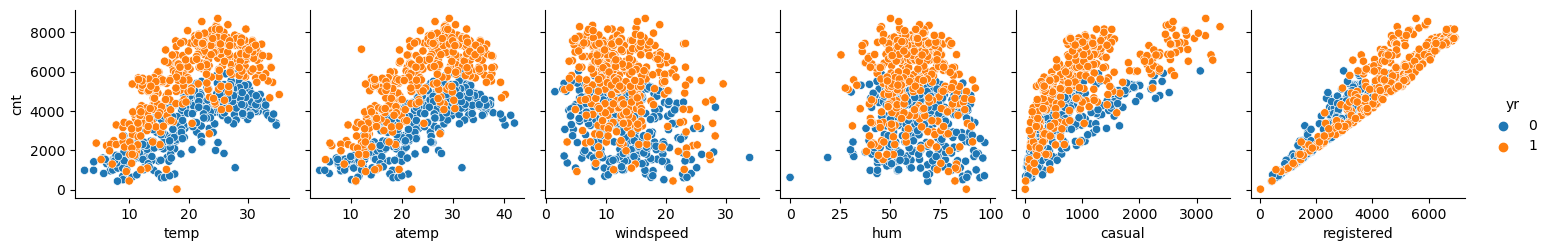

In [25]:
# Visualization of Relationship of Numerical Features against Target Variable
sns.pairplot(day, x_vars=["temp",'atemp', 'windspeed',"hum",'casual','registered'],y_vars=['cnt'],hue ='yr')
plt.show()


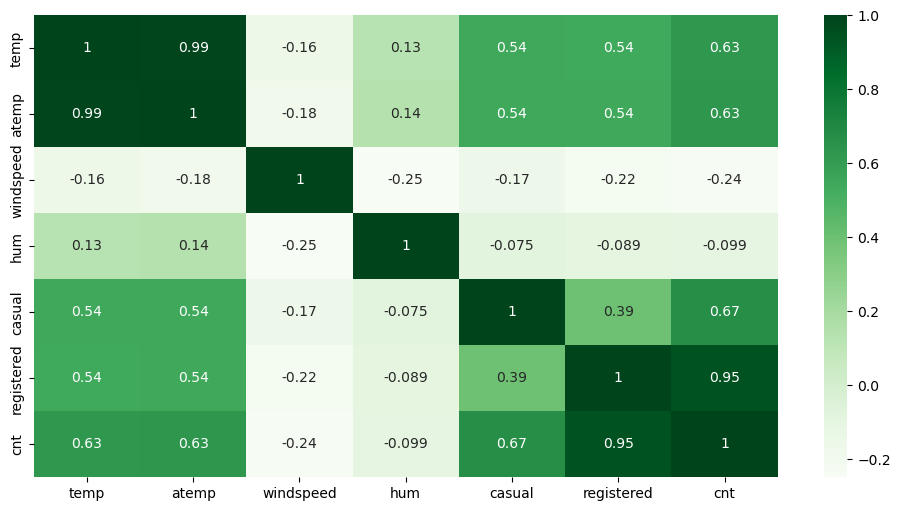

In [26]:
plt.figure(figsize = (12,6))
sns.heatmap(day[["temp",'atemp', 'windspeed',"hum",'casual','registered','cnt']].corr(),annot =True, cmap="Greens")
plt.show()

### Based on the observations from the plots:

1. **Registered users and correlation with target variable:**
   - It's noted that registered bike users are more numerous than casual users and show a strong correlation with the target variable.

2. **Correlation between 'temp' and 'atemp':**
   - 'temp' and 'atemp' are highly correlated, suggesting that one of them can be dropped to avoid multicollinearity in predictive modeling.

3. **Effect of humidity on the target variable:**
   - Humidity appears to have little negative effect on the target variable, indicating it may not be a strong predictor.

4. **Casual and registered users as potential target features:**
   - Since the number of casual and registered users contributes directly to the target variable ('cnt'), these features can be considered part of the target variable. Thus, they can be dropped from the features used for modeling to prevent data leakage and maintain mode model integrity.

### In summary:

1. Drop one of **temp** or **atemp**edue to their high correlation. <br>
2. Consider excluding humidity from the feature set if its impact on the target variable is minimal. <br>
3. Treat **casual** and **registered** as components of the target variable (**cnt**) to avoid data leakage and maintain model integrity. <br>

In [27]:
day = day.drop(['atemp','casual','registered'],axis =1)

In [28]:
day.groupby(['Clear', 'Mist','Light','summer','fall','winter'])['cnt'].mean().sort_values(ascending = False)

Clear  Mist  Light  summer  fall  winter
1      0     0      0       1     0         5878.257353
                    1       0     0         5548.548673
0      1     0      0       1     0         5222.479167
1      0     0      0       0     1         5043.563107
0      1     0      0       0     1         4654.000000
                    1       0     0         4236.705882
1      0     0      0       0     0         2811.135135
0      0     1      0       1     0         2751.750000
       1     0      0       0     0         2365.215385
       0     1      0       0     1         1961.600000
                    1       0     0         1169.000000
                    0       0     0          934.750000
Name: cnt, dtype: float64

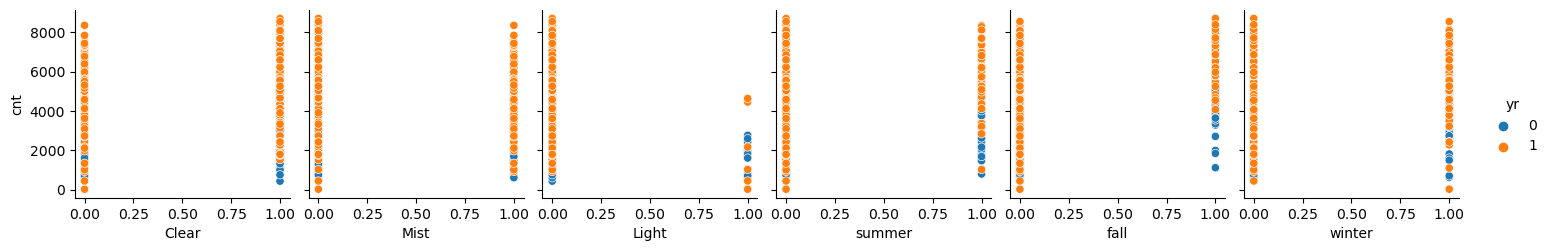

In [29]:
sns.pairplot(day,x_vars =['Clear', 'Mist','Light','summer','fall','winter'],y_vars='cnt',hue ='yr')
plt.show()

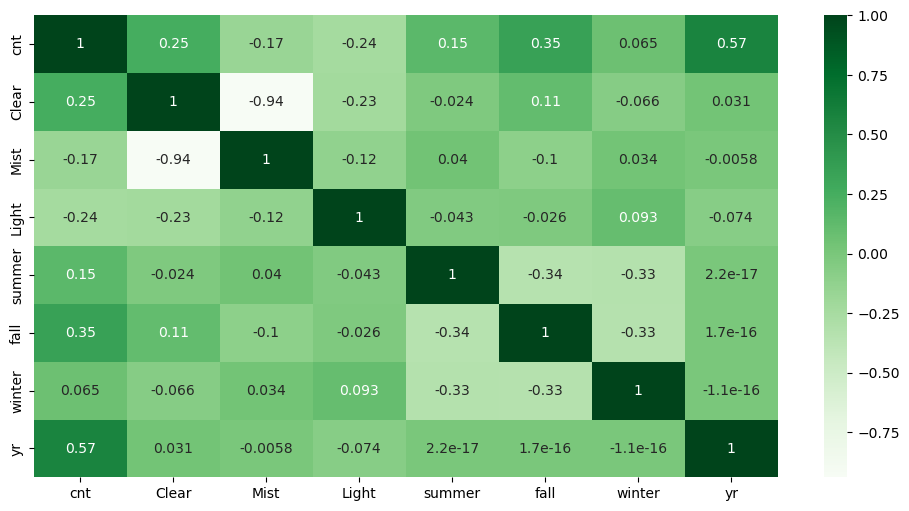

In [30]:
plt.figure(figsize = (12,6))
sns.heatmap(day[['cnt','Clear', 'Mist','Light','summer','fall','winter','yr']].corr(),annot =True, cmap="Greens")
plt.show()

In [31]:
day.groupby(['summer','fall','winter','Feb','March','April','May','June', \
             'July' ,'Aug','Sep','Oct','Nov','Dec'])['cnt'].mean().sort_values(ascending = False)

summer  fall  winter  Feb  March  April  May  June  July  Aug  Sep  Oct  Nov  Dec
0       0     1       0    0      0      0    0     0     0    1    0    0    0      6024.500000
1       0     0       0    0      0      0    1     0     0    0    0    0    0      5773.850000
0       1     0       0    0      0      0    1     0     0    0    0    0    0      5769.400000
                                              0     0     0    1    0    0    0      5672.704545
                                                          1    0    0    0    0      5664.419355
                                                    1     0    0    0    0    0      5563.677419
1       0     0       0    0      0      1    0     0     0    0    0    0    0      5349.774194
0       0     1       0    0      0      0    0     0     0    0    1    0    0      5199.225806
1       0     0       0    0      1      0    0     0     0    0    0    0    0      4484.900000
0       0     1       0    0      0      0   

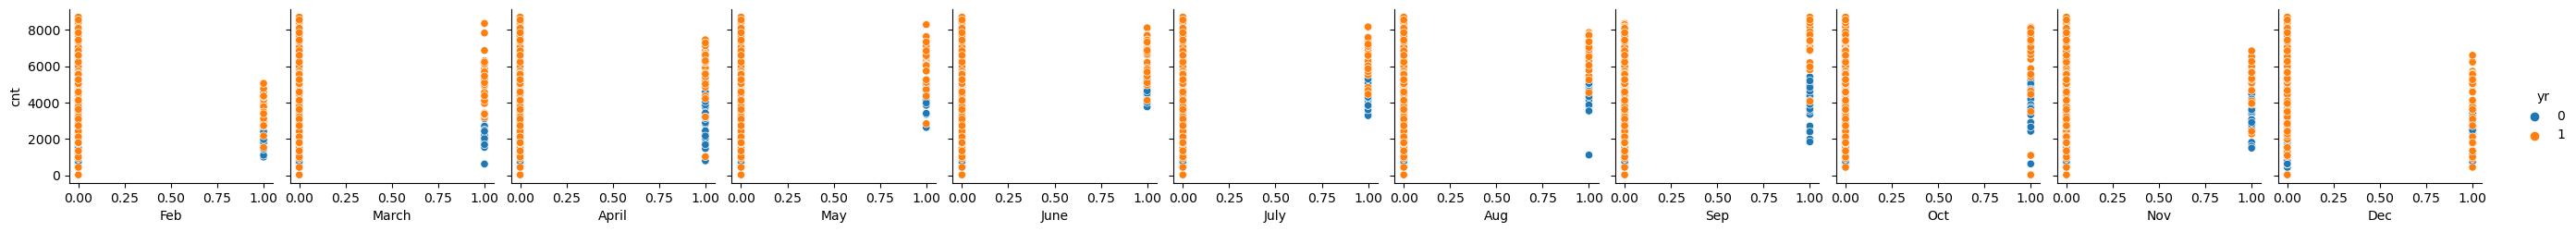

In [32]:
sns.pairplot(day,x_vars =['Feb','March','April','May','June','July' ,'Aug','Sep','Oct','Nov','Dec'],y_vars='cnt',hue ='yr')
plt.show()

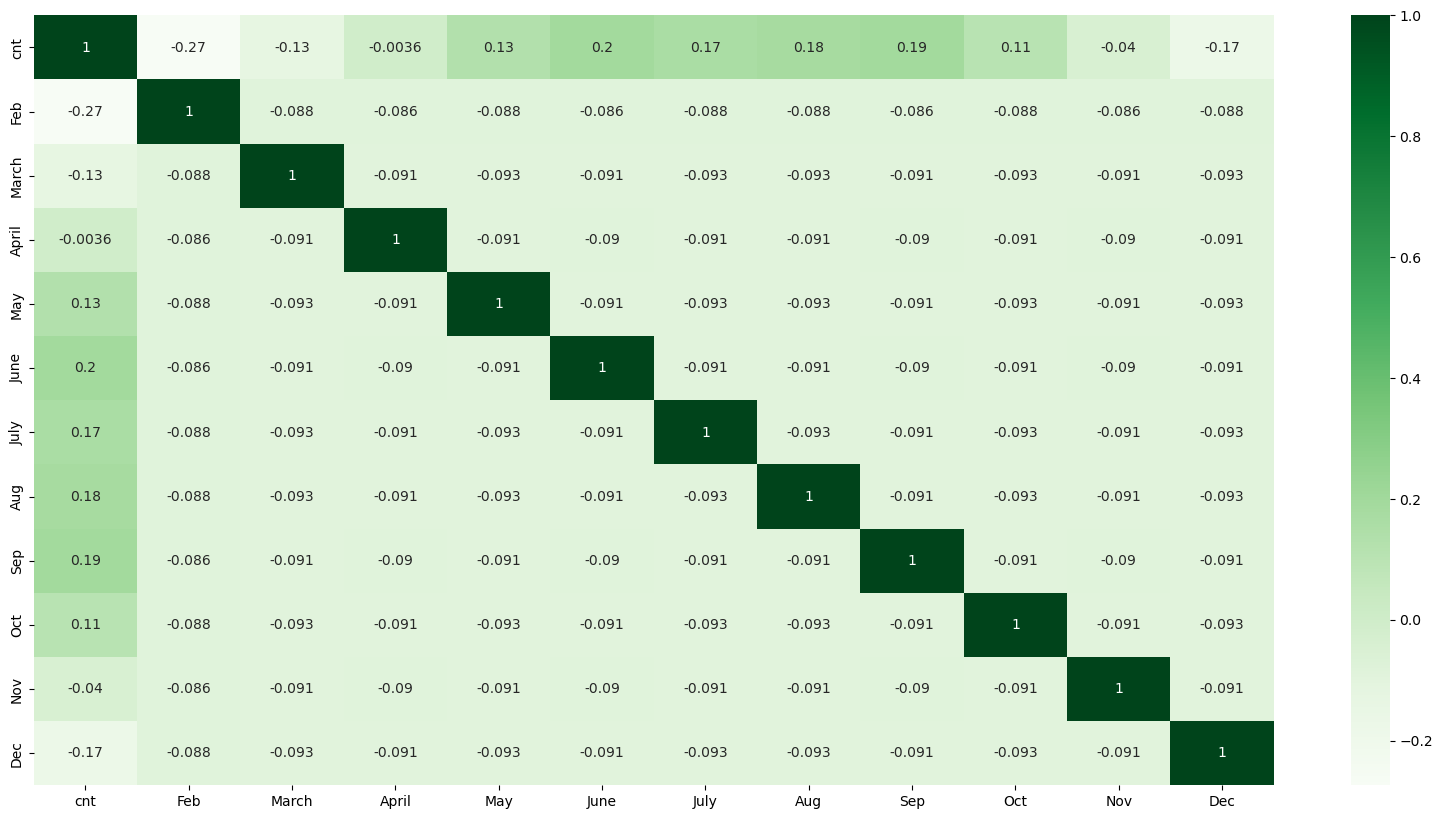

In [33]:
plt.figure(figsize = (20,10))
sns.heatmap(day[['cnt','Feb','March','April','May','June','July' ,'Aug','Sep','Oct','Nov','Dec']].corr(),annot = True, cmap="Greens")
plt.show()

* In 2019, the peak rental month was September, contrasting with June in the preceding year.

* During winter, there is generally higher demand for bike rentals.

In [34]:
day.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'summer', 'fall', 'winter', 'Feb', 'March', 'April', 'May', 'June',
       'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Monday', 'Tuesday',
       'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Clear', 'Mist',
       'Light'],
      dtype='object')

In [35]:
day.groupby(['holiday', 'workingday','summer','fall','winter'])['cnt'].mean().sort_values(ascending = False)

holiday  workingday  summer  fall  winter
0        1           0       1     0         5718.114504
1        0           0       1     0         5707.750000
0        0           0       1     0         5457.075472
                     1       0     0         5160.365385
         1           1       0     0         4926.664062
1        0           1       0     0         4909.250000
0        1           0       0     1         4785.611570
         0           0       0     1         4674.549020
1        0           0       0     1         4025.333333
0        1           0       0     0         2788.495798
         0           0       0     0         2330.888889
1        0           0       0     0         1687.857143
Name: cnt, dtype: float64

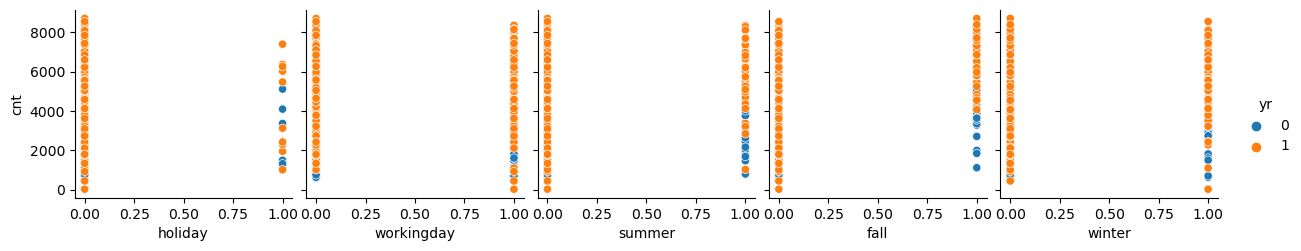

In [36]:
sns.pairplot(day,x_vars =['holiday', 'workingday','summer','fall','winter'],y_vars='cnt',hue ='yr')
plt.show()

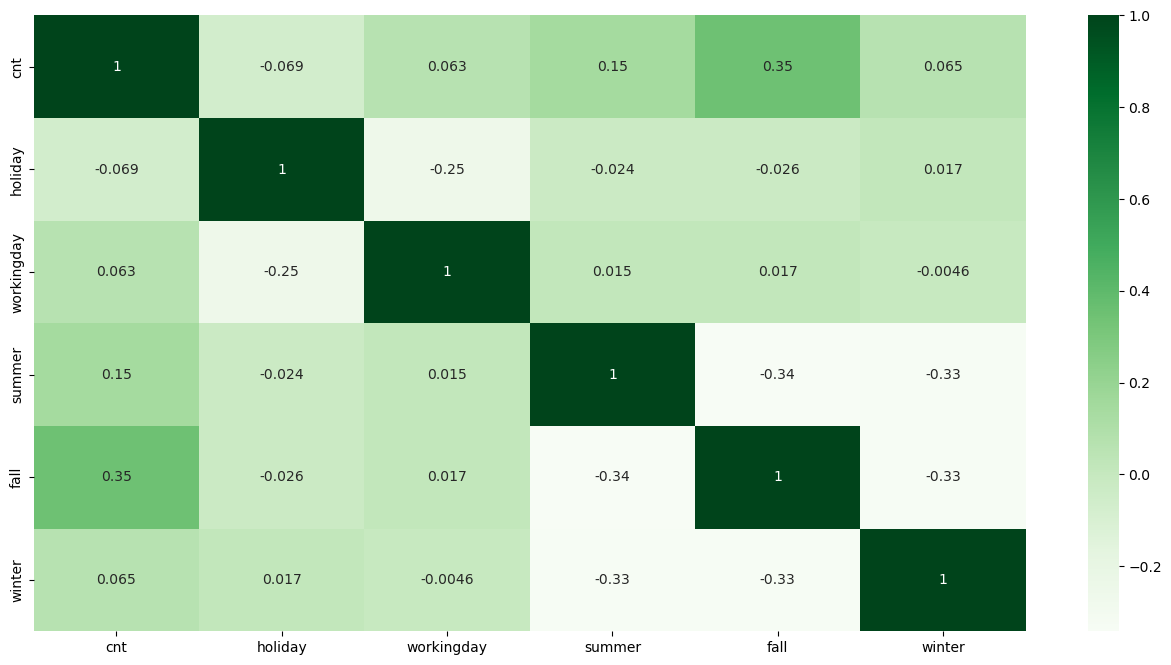

In [37]:
plt.figure(figsize = (16,8))
sns.heatmap(day[['cnt','holiday', 'workingday','summer','fall','winter']].corr(),annot = True, cmap="Greens")
plt.show()

### Based on the observations provided:

1. Bike rentals peak during weekdays, suggesting higher usage for commuting or regular activities during the workweek.
2. Clear weather conditions are preferred for bike rentals, indicating users may avoid renting bikes during adverse weather.
3. Bike rentals are lowest on holidays, possibly due to fewer people commuting or engaging in routine activities.
4. There has been an increase in bike rentals in 2019 compared to 2018, indicating growing business and popularity for the bike rental service.

These observations highlight trends and patterns in bike rental behavior across different conditions and time periods, offering insights that can be valuable for business strategy and operational planning.

## **Data Modelling - Splitting the data into Train and Testing Sets**:

In [38]:
# Splitting the Data into Training and Testing Sets
df_train,df_test = train_test_split(day,train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


In [39]:
# As we saw that Data we were unfiform across the all the Features hence Scaling is Required.
scaler = MinMaxScaler()

# Create a list of Numerical Variables which need to Scaled
num_vars = ['temp', 'windspeed',"hum",'cnt']

# For the Training Data Fit and Transform both need to done.
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])

# View the Statistical Description to ensure MinMax Scaling has done properly
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,510.0,0.507843,0.500429,0.0,0.000000,1.000000,1.000000,1.0
holiday,510.0,0.025490,0.157763,0.0,0.000000,0.000000,0.000000,1.0
workingday,510.0,0.676471,0.468282,0.0,0.000000,1.000000,1.000000,1.0
temp,510.0,0.537440,0.225858,0.0,0.339853,0.542596,0.735215,1.0
hum,510.0,0.650480,0.145846,0.0,0.538643,0.653714,0.754830,1.0
windspeed,510.0,0.320883,0.169803,0.0,0.199179,0.296763,0.414447,1.0
cnt,510.0,0.513499,0.224421,0.0,0.356420,0.518638,0.684710,1.0
summer,510.0,0.247059,0.431725,0.0,0.000000,0.000000,0.000000,1.0
fall,510.0,0.262745,0.440557,0.0,0.000000,0.000000,1.000000,1.0
winter,510.0,0.247059,0.431725,0.0,0.000000,0.000000,0.000000,1.0


#### It sounds like the MinMax scaling process has been effectively applied to the training data. Each feature now ranges from a minimum of 0 to a maximum of 1, which is indicative of successful normalization. This scaling ensures that all features are on a comparable scale, which is crucial for many machine learning algorithms to perform optimally.

In [40]:
# Preparation of Training Dataset
y_train = df_train.pop('cnt')
X_train = df_train
print(X_train.shape)
y_train.sample(5)

(510, 29)


374    0.411413
115    0.503682
695    0.452945
514    0.786125
76     0.370110
Name: cnt, dtype: float64

## **Feature Selection using RFE - Recursive Feature Elimination**:

In [44]:
# Running RFE with the Output Number of variables equals to 15
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [46]:
# Running RFE
# Create the RFE object with the desired number of features
rfe = RFE(estimator=lm, n_features_to_select=15)

# Fit RFE to your training data
rfe = rfe.fit(X_train, y_train)

In [47]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('summer', True, 1),
 ('fall', False, 2),
 ('winter', True, 1),
 ('Feb', False, 7),
 ('March', False, 3),
 ('April', False, 5),
 ('May', False, 4),
 ('June', False, 6),
 ('July', False, 9),
 ('Aug', True, 1),
 ('Sep', True, 1),
 ('Oct', True, 1),
 ('Nov', False, 15),
 ('Dec', False, 12),
 ('Monday', False, 8),
 ('Tuesday', False, 10),
 ('Wednesday', False, 13),
 ('Thrusday', False, 14),
 ('Friday', False, 11),
 ('Saturday', True, 1),
 ('Clear', True, 1),
 ('Mist', True, 1),
 ('Light', True, 1)]

In [48]:
# RFE Selected Features
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'winter', 'Aug', 'Sep', 'Oct', 'Saturday', 'Clear', 'Mist', 'Light'],
      dtype='object')

In [49]:
# Features Rejected by the RFE
X_train.columns[~(rfe.support_)]

Index(['fall', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Nov', 'Dec',
       'Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday'],
      dtype='object')

### **Building a Model using statsmodels for detailed statistics**:

In [50]:
# Creating X train with RFE Selected Variables
X_train_rfe = X_train[col]

In [51]:
# Adding Constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Create Object for the Model
lm = sm.OLS(y_train, X_train_rfe).fit()

# View Summary of Statistics
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          8.70e-192
Time:                        14:02:03   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0701      0.025      2.765      0.006       0.020       0.120
yr             0.2292      0.008     28.712      0.000       0.214       0.245
holiday       -0.0557      0.027     -2.069      0.039      -0.109      -0.003
workingday     0.0442      0.012      3.829      0.000       0.022       0.067
temp           0.5309      0.022     24.146      0.000       0.488       0.574
hum           -0.1708      0.037     -4.620      0.000      -0.243      -0.098
windspeed     -0.1858      0.025     -7.353      0.000      -0.235      -0.136
summer         0.1049      0.011      9.778      0.000       0.084       0.126
winter         0.1349      0.012     11.306      0.000       0.111       0.158
Aug            0.0557      0.016      3.457      0.001       0.024       0.087
Sep            0.1252      0.016      7.757      0.000       0.093       0.157
Oct            0.0385      0.017      2.230      0.026       0.005       0.072
Saturday       0.0527      0.015      3.627      0.000       0.024       0.081
Clear          0.1246      0.009     14.641      0.000       0.108       0.141
Mist           0.0679      0.011      5.937      0.000       0.045       0.090
Light         -0.1224      0.022     -5.604      0.000      -0.165      -0.079
==============================================================================
Omnibus:                       70.710   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.743
Skew:                          -0.710   Prob(JB):                     4.18e-39
Kurtosis:                       5.511   Cond. No.                     2.33e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.09e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

> As the Statistics Report say there is strong multicollinearity problems so we need to check for VIF

In [52]:
# Calculation of VIF
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
13,Clear,inf
14,Mist,inf
15,Light,inf
3,workingday,1.88
5,hum,1.87
12,Saturday,1.79
8,winter,1.71
4,temp,1.59
11,Oct,1.49
9,Aug,1.46


In [53]:
# As VIF is Infnity for the Feature 'Clear' so we can drop it 
X_train_rfe = X_train_rfe.drop('Clear',axis=1)
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'summer', 'winter', 'Aug', 'Sep', 'Oct', 'Saturday', 'Mist', 'Light'],
      dtype='object')

In [54]:
# Add constant to all the Variables
X_train_sm = sm.add_constant(X_train_rfe)
# Create the Model
lr = sm.OLS(y_train, X_train_sm)
# Fit the Model
lr_model = lr.fit()
# View the Parameter of the Model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          8.70e-192
Time:                        14:02:49   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1948      0.029      6.769      0.000       0.138       0.251
yr             0.2292      0.008     28.712      0.000       0.214       0.245
holiday       -0.0557      0.027     -2.069      0.039      -0.109      -0.003
workingday     0.0442      0.012      3.829      0.000       0.022       0.067
temp           0.5309      0.022     24.146      0.000       0.488       0.574
hum           -0.1708      0.037     -4.620      0.000      -0.243      -0.098
windspeed     -0.1858      0.025     -7.353      0.000      -0.235      -0.136
summer         0.1049      0.011      9.778      0.000       0.084       0.126
winter         0.1349      0.012     11.306      0.000       0.111       0.158
Aug            0.0557      0.016      3.457      0.001       0.024       0.087
Sep            0.1252      0.016      7.757      0.000       0.093       0.157
Oct            0.0385      0.017      2.230      0.026       0.005       0.072
Saturday       0.0527      0.015      3.627      0.000       0.024       0.081
Mist          -0.0568      0.010     -5.482      0.000      -0.077      -0.036
Light         -0.2470      0.026     -9.484      0.000      -0.298      -0.196
==============================================================================
Omnibus:                       70.710   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.743
Skew:                          -0.710   Prob(JB):                     4.18e-39
Kurtosis:                       5.511   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# Again Checking the VIF Score
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,const,53.47
3,workingday,1.88
5,hum,1.87
12,Saturday,1.79
8,winter,1.71
4,temp,1.59
13,Mist,1.56
11,Oct,1.49
9,Aug,1.46
7,summer,1.38


In [56]:
X_train_rfe.shape

(510, 15)

**The low Prob(F-statistic) indicates a strong overall model fit.** <br>
**We achieved a commendable Adjusted R-squared score of 84.3%.** <br>
**All p-values are below 0.05, confirming the statistical significance of all 14 features.** <br>
**Therefore, we are confident in proceeding with this model for prediction and evaluation tasks.** <br>

## **Residual Analysis**:

In [57]:
# Calculation of Error in Prediction for Training Data
y_train_pred = lr_model.predict(X_train_sm)
res = (y_train - y_train_pred)

### **Assessing the Assumption - Normality**:

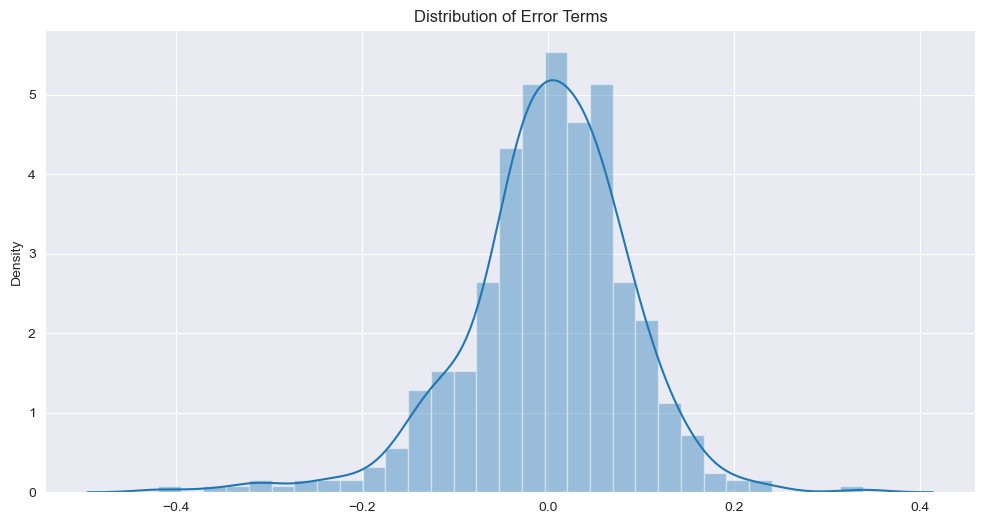

In [58]:
# Ploting of Residuals
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
sns.distplot(res)
plt.title('Distribution of Error Terms')
plt.show()

**The error terms exhibit a normal distribution centered around zero, affirming that the model conforms to the assumption of Normality.**

### **Analyzing Residual Patterns**:

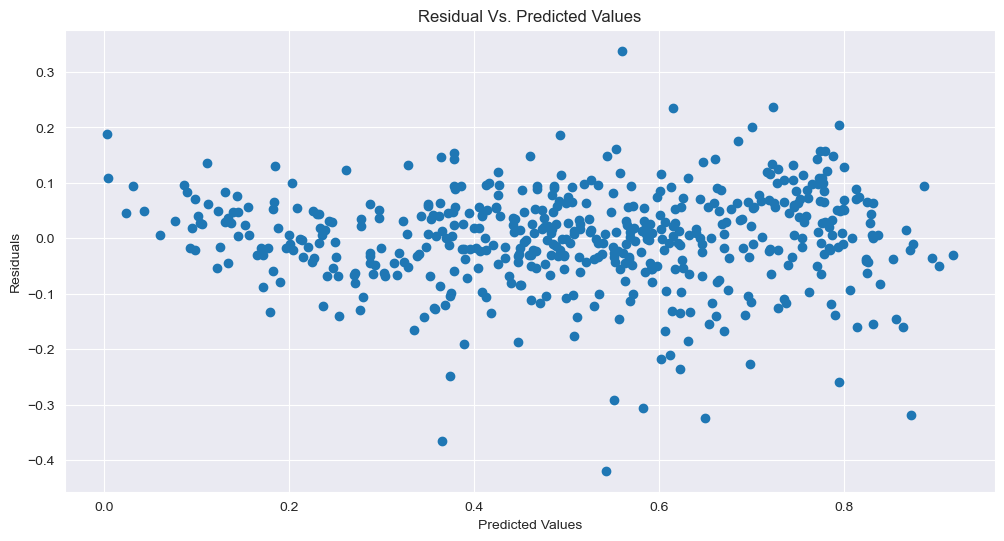

In [59]:
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
plt.scatter(y_train_pred,res)
plt.title('Residual Vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

**No discernible patterns are observed in the error terms relative to predictions, indicating that the error terms are independent of each other.**

### **Assessing Homoscedasticity - Constant Variance:**

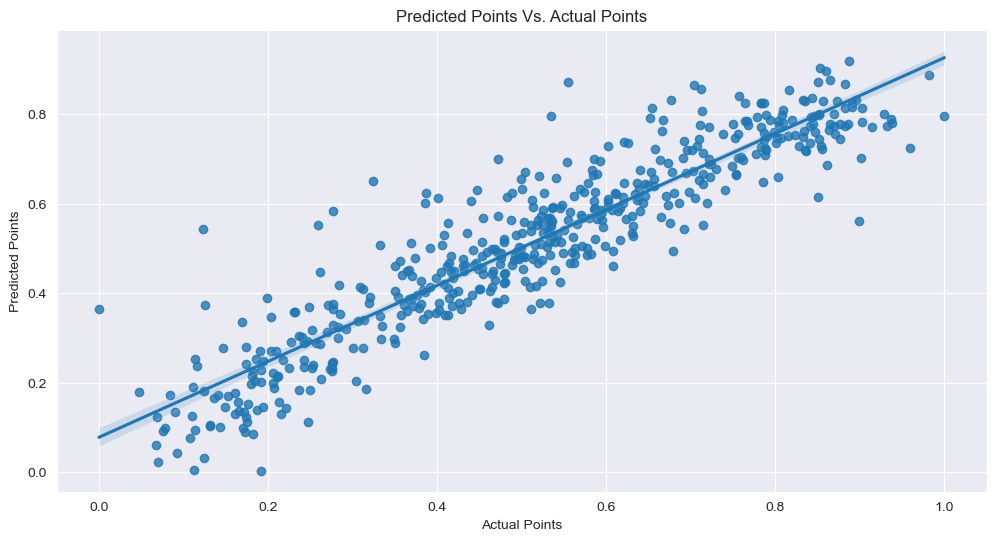

In [60]:
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
sns.regplot(x=y_train, y=y_train_pred)
plt.title('Predicted Points Vs. Actual Points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.show()

**The error terms exhibit approximately constant variance, indicating adherence to the assumption of homoscedasticity.**

## **Model Evaluation on Test Dataset**:

#### **Applying MinMax scaling on the test sets**:

In [61]:
num_vars = ['temp', 'windspeed',"hum",'cnt']

df_test[num_vars]=scaler.transform(df_test[num_vars])

y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,hum,windspeed,summer,fall,winter,...,Dec,Monday,Tuesday,Wednesday,Thrusday,Friday,Saturday,Clear,Mist,Light
184,1.0,0,1,0,0.831783,0.657364,0.084219,0,1,0,...,0,1,0,0,0,0,0,0,1,0
535,1.0,1,0,1,0.901354,0.610133,0.153728,1,0,0,...,0,0,0,1,0,0,0,1,0,0
299,1.0,0,0,1,0.511964,0.837699,0.334206,0,0,1,...,0,0,0,0,1,0,0,0,1,0
221,1.0,0,0,1,0.881625,0.437098,0.339570,0,1,0,...,0,0,0,1,0,0,0,1,0,0
152,1.0,0,0,1,0.817246,0.314298,0.537414,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [62]:
#Dropping the Features which were eliminated during the Training Process
X_test_sm = X_test_sm.drop(['fall', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Nov', 'Dec', \
       'Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday','Clear'],axis=1)

# Predict the Price for Test Data using the Trainned Model
y_test_pred = lr_model.predict(X_test_sm)

y_test_pred.sample(5)

379    0.337916
169    0.525170
46     0.252176
453    0.581543
367    0.321493
dtype: float64

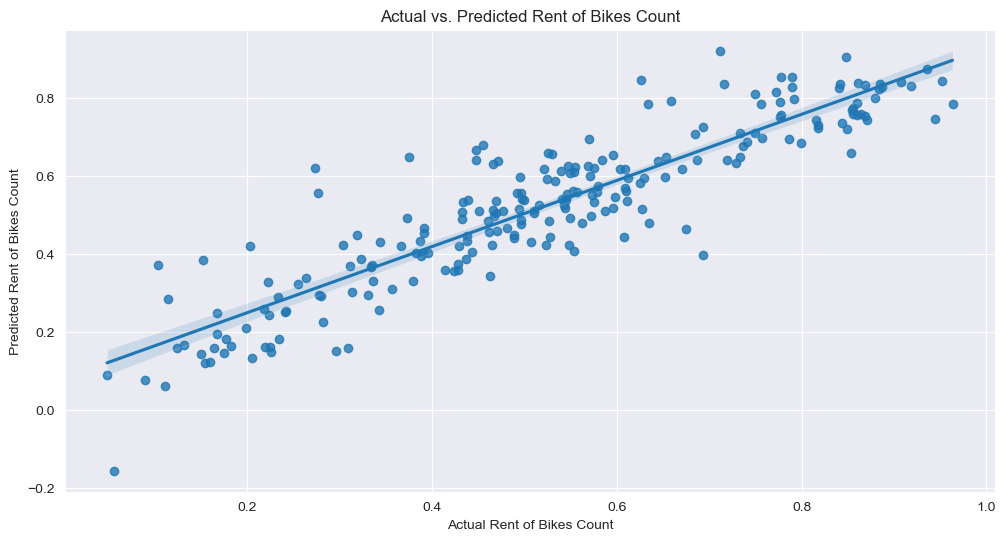

In [63]:
# Plotting y_test and y_pred to understand the spread.
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
sns.regplot(x=y_test, y=y_test_pred)
plt.title('Actual vs. Predicted Rent of Bikes Count')
plt.xlabel('Actual Rent of Bikes Count')
plt.ylabel('Predicted Rent of Bikes Count')
plt.show()

**The scatter plot above illustrates the linear relationship between the actual count of rented bikes and the predicted count.**

In [64]:
# Checking the Accuracy of the Test Model
r2_score(y_test,y_test_pred)

0.8149002944843475

**The final model achieves an accuracy of approximately 81.5%, which is considered quite good.**

**The difference in accuracy between the training and test data sets is less than 3%, which is within an acceptable range.**

In [65]:
Cofficients = round(lr_model.params,2)
beta = Cofficients.sort_values(ascending = False)
beta

temp          0.53
yr            0.23
const         0.19
winter        0.13
Sep           0.13
summer        0.10
Aug           0.06
Saturday      0.05
workingday    0.04
Oct           0.04
holiday      -0.06
Mist         -0.06
hum          -0.17
windspeed    -0.19
Light        -0.25
dtype: float64

In [66]:
for i in range(0, len(beta)):
    print(beta[i],'*',beta.index[i],end ='')
    print(' + ',end ='')

0.53 * temp + 0.23 * yr + 0.19 * const + 0.13 * winter + 0.13 * Sep + 0.1 * summer + 0.06 * Aug + 0.05 * Saturday + 0.04 * workingday + 0.04 * Oct + -0.06 * holiday + -0.06 * Mist + -0.17 * hum + -0.19 * windspeed + -0.25 * Light + 

**Equation of the Best Fit Line :**

**cnt = 0.53 * temp + 0.23 * yr  + 0.13 * winter + 0.13 * Sep + 0.1 * summer + 0.06 * Aug + 0.05 * Saturday + 0.04 * workingday + 0.04 * Oct - 0.06 * holiday - 0.06 * Mist - 0.17 * hum - 0.19 * windspeed - 0.25 * Light + 0.19**

## **Insights:**

1. **Temperature emerges as the most significant factor positively impacting business performance.**  
 
2. **Conversely, adverse environmental conditions such as rain, humidity, windspeed, and cloudy skies have a negative effect on business.**
 
3. **The company should strategize solutions to mitigate the impact of bad weather conditions, especially rain, on user experience.** 

4. **Demand for bike rentals peaks during winter and summer seasons, indicating a preference for biking in dry weather conditions.** 

5. **Interestingly, Saturdays show a notably higher demand for bike rentals compared to other weekdays.** 
   
6. **The year-over-year comparison reveals a substantial increase in bike rental demand from 2018 to 2019, reflecting positive business growth for Boom Bikes.** 

7. **Moreover, even without additional investment, Boom Bikes can anticipate a business growth potential of 19%.**